# CYP21A2
to do

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.4.2.dev0


In [2]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator

cohort_name = "CYP21A2"	


cohort_creator = configure_caching_cohort_creator(hpo)
from gpsea.preprocessing import load_phenopacket_folder
pp_dir = '/Users/robin/GIT/phenopacket-store/notebooks/CYP21A2/phenopackets/'
cohort, qc_results = load_phenopacket_folder(pp_dir, cohort_creator)  



Individuals Processed: 69individuals [00:31,  2.16individuals/s]


In [3]:
from pyphetools.visualization import PhenopacketIngestor
pp_dir = '/Users/robin/GIT/phenopacket-store/notebooks/CYP21A2/phenopackets'
ingestor = PhenopacketIngestor(indir=pp_dir)
ppkt_lst = ingestor.get_phenopacket_list()


[pyphetools] Ingested 69 GA4GH phenopackets.


In [4]:
gene_symbol = 'CYP21A2'
mane_tx_id = 'NM_000500.9'
mane_protein_id = 'NP_000491.4' # steroid 21-hydroxylase isoform a [Homo sapiens]

# "id": "LOINC:2986-8",
        "label": "Testosterone[Mass/Vol]"

#  

In [5]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates
is_missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
is_missense.get_question()
from gpsea.analysis.predicate.genotype import autosomal_dominant
gt_predicate = autosomal_dominant(
    is_missense,
)
gt_predicate.display_question()


'What is the genotype group: No allele, Monoallelic'

In [13]:
from gpsea.analysis.pscore import MeasurementPhenotypeScorer, PhenotypeScoreAnalysisResult
from gpsea.analysis.pscore.stats import TTestStatistic
from gpsea.analysis.pscore import PhenotypeScoreAnalysis
from gpsea.analysis.predicate.genotype import GenotypePolyPredicate
from gpsea.model import Cohort

def perform_t_test(loinc_id: str,
                   cohort: Cohort,
                   gt_predicate: GenotypePolyPredicate) -> PhenotypeScoreAnalysisResult:
    pheno_scorer = MeasurementPhenotypeScorer.from_measurement_id(
        term_id=loinc_id,
    )
    score_statistic = TTestStatistic()
    score_analysis = PhenotypeScoreAnalysis(
        score_statistic=score_statistic,
    )
    result = score_analysis.compare_genotype_vs_phenotype_score(
        cohort=cohort,
        gt_predicate=gt_predicate,
        pheno_scorer=pheno_scorer,
    )
    return result

In [14]:
loinc_id = 'LOINC:2986-8'
result = perform_t_test(loinc_id=loinc_id, cohort=cohort, gt_predicate=gt_predicate)
print(f"t test for {loinc_id}: {result.pval}")

t test for LOINC:2986-8: 0.4101488652309173


In [15]:
loinc_id = "LOINC:2842-3"
result = perform_t_test(loinc_id=loinc_id, cohort=cohort, gt_predicate=gt_predicate)
print(f"prolactin: t test for {loinc_id}: {result.pval}")

t test for LOINC:2842-3: 0.14006452876212716


In [16]:
loinc_id = "LOINC:2143-6"
result = perform_t_test(loinc_id=loinc_id, cohort=cohort, gt_predicate=gt_predicate)
print(f"cortisol: t test for {loinc_id}: {result.pval}")

cortisol: t test for LOINC:2143-6: 0.11519016915840528


In [17]:
loinc_id ="LOINC:2141-0"
result = perform_t_test(loinc_id=loinc_id, cohort=cohort, gt_predicate=gt_predicate)
print(f"Corticotropin (ACTH): t test for {loinc_id}: {result.pval}")

Corticotropin (ACTH): t test for LOINC:2141-0: 0.30161249303540155


In [21]:
loinc_id ="LOINC:1668-3"
result = perform_t_test(loinc_id=loinc_id, cohort=cohort, gt_predicate=gt_predicate)
print(f"17-Hydroxyprogesterone: t test for {loinc_id}: {result.pval}")

17-Hydroxyprogesterone: t test for LOINC:1668-3: 0.0001382123104478872


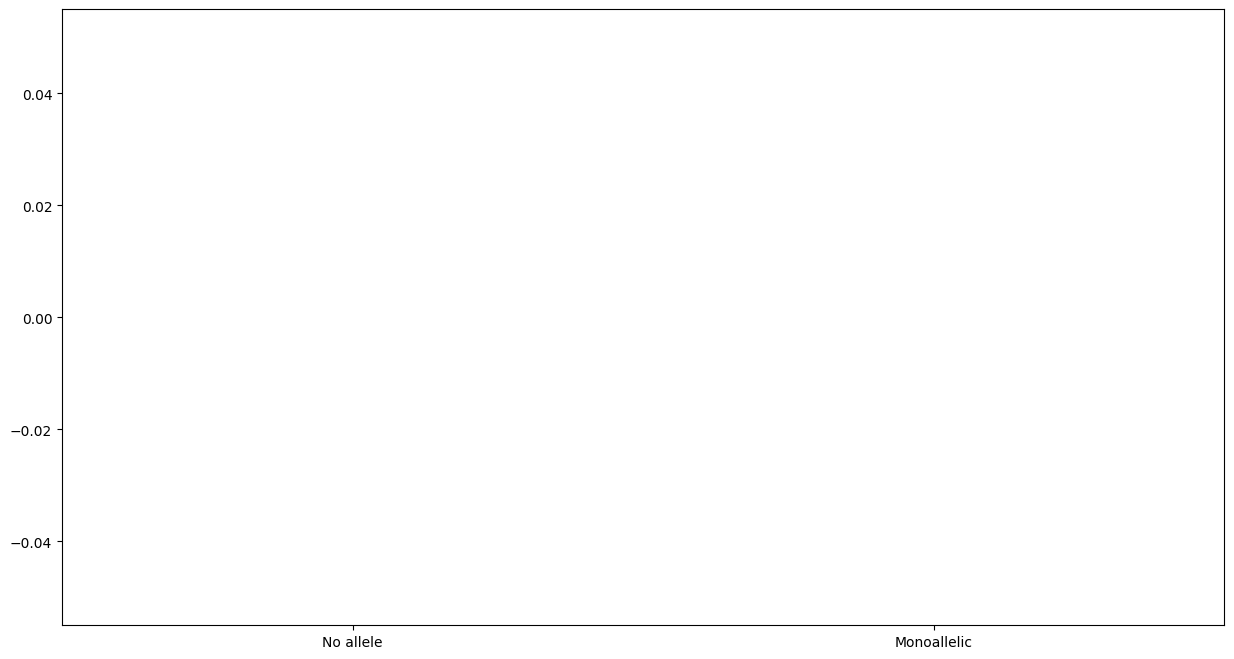

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))
result.plot_boxplots(gt_predicate=gt_predicate, ax=ax)

In [20]:
scores = result.genotype_phenotype_scores.sort_index()
scores.head()  

,genotype,phenotype
patient_id,,
individual 10[PMID_30968594_individual_10],0,31.74
individual 11[PMID_30968594_individual_11],1,0.01
individual 12[PMID_30968594_individual_12],0,NaN
individual 13[PMID_30968594_individual_13],0,24.92
individual 14[PMID_30968594_individual_14],0,29.53


[Text(0, 0, 'missense'), Text(1, 0, 'other')]

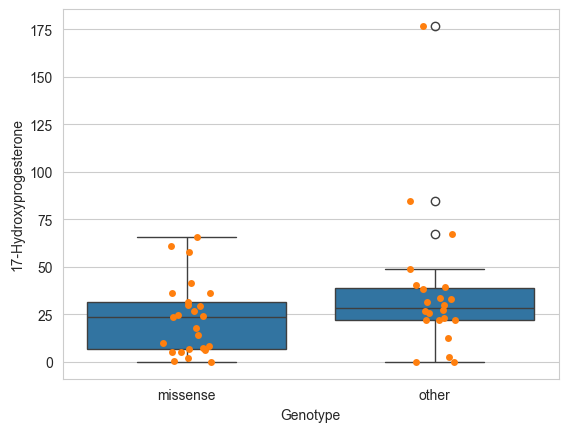

In [61]:
filtered_df = scores[scores['phenotype'].notnull()]
filtered_df = scores[scores['genotype'].notnull()]
filtered_df.head()
import seaborn as sns
sns.set_style('whitegrid')
ax = sns.boxplot(x='genotype',y='phenotype',data=filtered_df).set(
    xlabel='Genotype', 
    ylabel='17-Hydroxyprogesterone'
)
ax = sns.stripplot(x="genotype", y="phenotype",data=filtered_df)
labels = ax.get_xticklabels()
ax.set_xticks([0, 1])
new_labels = ["missense", "other"]
ax.set_xticklabels(new_labels)

In [60]:
labels = ax.get_xticklabels()
ax.set_xticks([0, 1])
new_labels = ["missense", "other"]
ax.set_xticklabels(new_labels)
plt.show()

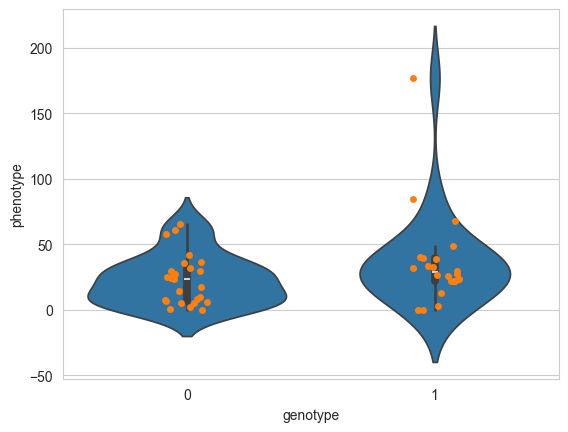

In [32]:
ax = sns.violinplot(x='genotype',y='phenotype',data=filtered_df)
ax = sns.stripplot(x='genotype',y='phenotype',data=filtered_df)

In [41]:
import numpy as np
from scipy.stats import mannwhitneyu, normaltest
from statannotations.Annotator import Annotator

In [45]:
pairs = [('0', '1')  ]
pvalues = [   0.0001382123104478872 ]
annotator = Annotator(ax, pairs)
annotator.set_pvalues(pvalues)
annotator.annotate()

TypeError: 'NoneType' object is not iterable

<Figure size 640x480 with 0 Axes>

In [8]:
scores = result.genotype_phenotype_scores.sort_index()
scores.head()  








,genotype,phenotype
patient_id,,
individual 10[PMID_30968594_individual_10],0,614.0
individual 11[PMID_30968594_individual_11],1,630.0
individual 12[PMID_30968594_individual_12],0,NaN
individual 13[PMID_30968594_individual_13],0,303.0
individual 14[PMID_30968594_individual_14],0,664.0
